# Data Preprocessing for Metabolomics
Metabolites are detected by using specific detection techniques (compound detection). 

Raw signals are then pre-processed to produce data in a suitable format for subsequent statistical analysis (data pre-processing). 

Then, data normalization is used to reduce the system and technical bias. For untargeted studies, metabolites are identified from spectral information in some given database (data processing).

## Steps for preprocessing
- Baseline correction (Noise filtering)
- Peak detection
- Peak alignment
- Normalization
- Pre-processing
- Pre-analytic

## Baseline correction

The original spectrum usually has a distorted baseline, which masks our signal. This needs to be smoothed out so that the peaks will signify true signal and true intensities.

<div>
<img src="./images/data-preprocessing/baseline-correction.png" width="300">
</div>

### Code for baseline correction

In [1]:
 pip install pyteomics lxml matplotlib scipy peakutils

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from pyteomics import mzml

In [3]:
mzml_file = "../../mzml_data/test.mzML"

In [4]:
def organize_spectrum_df(spectrum_df):
    spectrum_df['combined_array'] = spectrum_df.apply(lambda row: list(zip(row['m/z array'], row['intensity array'])), axis=1)

    organized_df = spectrum_df.explode('combined_array')
    organized_df[['m/z', 'intensity']] = pd.DataFrame(organized_df['combined_array'].tolist(), index=organized_df.index)
    organized_df = organized_df.drop(['m/z array', 'intensity array', 'combined_array'], axis=1)
    organized_df = organized_df.reset_index(drop=True)
    organized_df = organized_df[['id', 'm/z', 'intensity']]

    return organized_df

In [5]:
def plot_spectrum(spectrum_df):
    spectrum_df.groupby('id').apply(lambda x: x.plot(x='m/z', y='intensity', logy=True, label=f'Scan {x["id"].iloc[0]}'))
    
    plt.xlabel('m/z')
    plt.ylabel('Intensity')
    plt.title('Mass Spectrometry Data for Spectrum')
    plt.legend()
    plt.show()

- First let's see what the data looks like

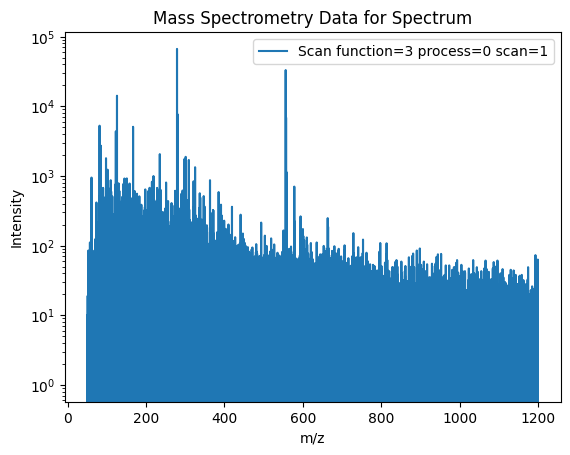

In [6]:
spectrum_list = list()

with mzml.read(mzml_file) as reader:
    for spectrum in reader:
        spectrum_list.append(spectrum)
        break

df = pd.DataFrame(spectrum_list)
plot_spectrum(organize_spectrum_df(df))

#### Apply baseline correction

- Baseline correction takes a **deg** parameter, which is the polynomial degree with which we fit the baseline with. I chose **6**, because it seemed to be working well with this data.
- After getting baseline, we substract it from the intensities
- As we can see from the plot, we have pretty weird values, with a lot of noise
- We need to smooth out these new values

In [7]:
import peakutils

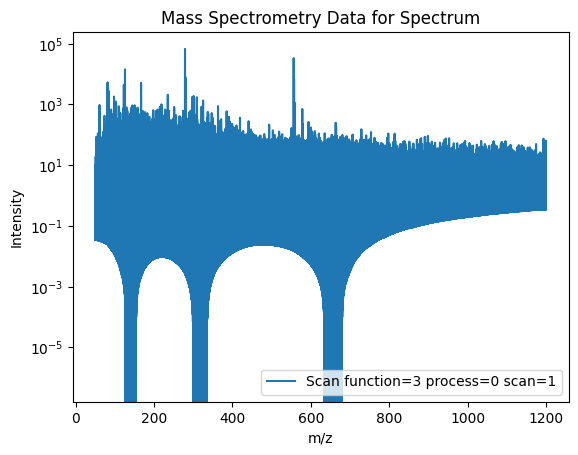

In [8]:
organized_spectrum = organize_spectrum_df(df)
baseline = peakutils.baseline(organized_spectrum["intensity"], deg=6)
organized_spectrum["intensity"] = organized_spectrum["intensity"] - baseline

plot_spectrum(organized_spectrum)

### Method for noise filtering
#### Gaussian filter

We apply **Gaussian filtering** to our data. This is useful for smoothing the data or reducing noise in mass spectrometry data.

I apply the filtering as well as baseline correction only on the **intensities** (rather than both m/z values and intensities) for the following reasons
- The **M/z** values typically represent the mass-to-charge ratio of ions detected by the mass spectrometer. These values are usually discrete and are not subject to noise in the same way that intensity values are
- Therefore applying a smoothing filter to m/z values may not be necessary or meaningful.
- Intensity values represent the abundance or signal strength of ions at specific m/z values. Intensity values are more prone to noise, fluctuations, and variations.
- Smoothing the intensity values with a Gaussian filter can help reduce noise, enhance the underlying signal, and improve the overall quality of the data.
- The Gaussian filter takes a **sigma** parameter. I chose **50**, because it seemed to be working well with this data.

In [9]:
from scipy.ndimage import gaussian_filter1d

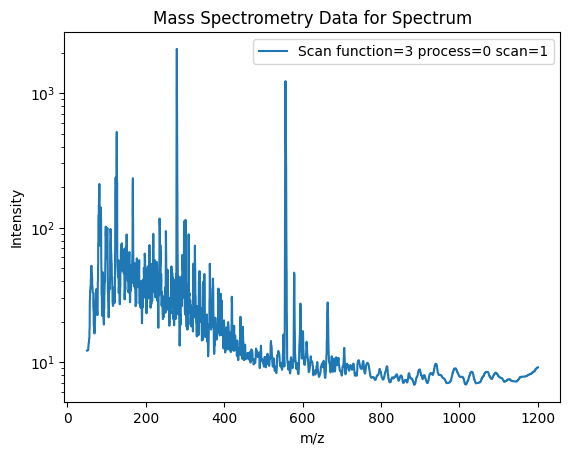

In [10]:
organized_spectrum["intensity"] = gaussian_filter1d(organized_spectrum["intensity"], 50)
plot_spectrum(organized_spectrum)

As we can see, the intensity values look much better now

When the Gaussian filter was applied, it smoothed the data by averaging neighboring values. 

If the original intensity values have fluctuations or noise, the filter will tend to reduce the amplitude of these fluctuations, resulting in a smoother profile.

The Gaussian filter also has a centering effect, where the smoothed values are influenced more by the central data points than by those on the periphery.

As a result, extreme values may be moderated, leading to a reduction in the amplitude of peaks and valleys.

## Peak detection

This is done by sample. Until now we considered only the intensities that needed smoothing, now we include **RT** value as well.

We want to determine peaks above specified noise level, these will represent our metabolite.

I chose the **peakutils.indexes** function for this job, it takes in a **threshold** and a **minimum distance** parameter. These can be further tuned.

Returns **RT** (Retention time), **m/z** (mass to charge ratio) and **integrated intensity** for each peak.

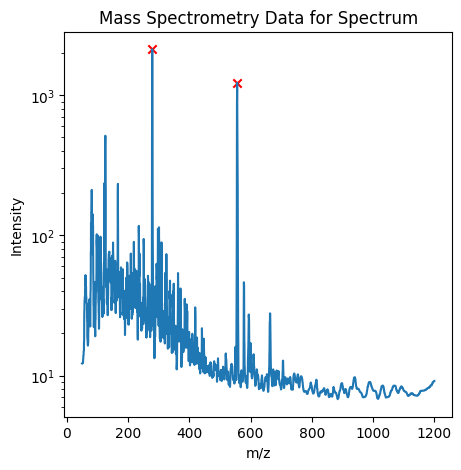

In [11]:
plt.figure(figsize=(5, 5))

plt.plot(organized_spectrum["m/z"], organized_spectrum["intensity"])

peaks = peakutils.indexes(organized_spectrum["intensity"], thres=0.5, min_dist=30)

plt.scatter(
    organized_spectrum["m/z"].iloc[peaks],
    organized_spectrum["intensity"].iloc[peaks],
    color="red",
    marker="x",
    label="Peaks",
)

plt.xlabel("m/z")
plt.ylabel("Intensity")
plt.title("Mass Spectrometry Data for Spectrum")
plt.yscale("log")
plt.show()

## Peak alignment

Here we have multiple samples.

It can be challeniging, because time of elution can vary across samples.

Alignment refers to find corresponding signals for the same compound across samples.

**Peak quality**: We should consider high quality peaks and filter out the low quality ones.

Methods suggestions:
- Before peak detection -> spectral alignment
  - Applying warping methods (stretch/shrink), non-linear transformations to RT to maximize correlation between spectra, Fast-Fourier methods
- Afer peak detection -> peak alignment
  - Applied to peak coordinates, identify RT boundaries of peaks, use kernel density estimators

<div>
<img src="./images/data-preprocessing/peak-alignment.jpg" width="300">
</div>

#### Method

The method I chose is based on a paper called **A Novel Peak Alignment Method for LC-MS Data Analysis Using Cluster-
based Techniques** that I got from Isin.

It involves the following steps:
- Basic definition
 - A sample with most peaks is selected and defined as **Master Data**
 - The rest of the samples are called **Test Data**
 - We also store all the peaks detected
- Peaks transformation
  - We define two restrictions: **adjMZWin** and **adjRTWin** (range for mz and range for RT)
  - If peak from Test Data is within the given ranges from Master Data we apply a transform function to **RT** in Master Data and another from the **RT** in the Test Data
- LOESS regression algorithm
  - After getting the peak transformed result between Master Data and Test Data, the next step is to find the regression equation from the transformed result
  - We define $$(x_k, y_k)$$
  - For each point we calculate **Q** span value: $$Q = \textit{f} \cdot n$$
  - Here **f** and **n** can be tuned
  - Then we calculate the **LOESS regression**
- Alignment
  - We sort the peaks in ascending order according to the **m/z** value
  - We can apply clustering to identify similar peaks
 
**Important note**: 
The paper states in the beginning of the definition:

"To begin with, a sample with most peaks selected from LC-MS-based samples is defined as Master Data. The rest samples in the LC-MS-based datasets are regarded as Test Data."

What if there are samples that have the same number of peaks?

#### Implementation including all steps from above

In [12]:
pip install scikit-learn statsmodels

Note: you may need to restart the kernel to use updated packages.


In [13]:
import statsmodels.api as sm

In [14]:
filtered_spectrum = list()
all_peaks = list()
spectrums = pd.DataFrame(columns=["id", "intensity", "m/z", "RT"])

peak_count = 0
master_data = list()

sample_count = 0

In [15]:
def organize_spectrum(spectrum_df):
    organized_data = []

    for _, row in spectrum_df.iterrows():
        m_z_array = row.get("m/z array", [])  
        intensity_array = row.get("intensity array", [])

        for mz, intensity in zip(m_z_array, intensity_array):
            entry = {
                "id": row["id"],
                "m/z": mz,
                "intensity": intensity,
                "RT": row["scanList"]["scan"][0]["scan start time"]
            }
            organized_data.append(entry)

    organized_df = pd.DataFrame(organized_data)

    return organized_df

In [16]:
with mzml.read(mzml_file) as reader:
    for spectrum in reader:
        if sample_count > 40:
            break;
        baseline = peakutils.baseline(spectrum["intensity array"], deg=6)
        spectrum["intensity array"] = spectrum["intensity array"] - baseline
        spectrum["intensity array"] = gaussian_filter1d(spectrum["intensity array"], 60)

        filtered_spectrum.append(spectrum)
        df = pd.DataFrame(filtered_spectrum)
        organized_spectrum = organize_spectrum(df)
        if not len(spectrums):
            spectrums = organized_spectrum
        else:
            spectrums = pd.concat([spectrums, organized_spectrum])

        peaks = peakutils.indexes(organized_spectrum["intensity"], thres=0.5, min_dist=30)

        for peak in peaks:
            all_peaks.append({
                "id": organized_spectrum["id"][peak],
                "m/z": organized_spectrum["m/z"][peak],
                "intensity": organized_spectrum["intensity"][peak],
                "RT": organized_spectrum["RT"][peak]
            })

        if len(peaks) > peak_count:
            master_data.clear()
            peak_count = len(peaks)
            for peak in peaks:
                master_data.append({
                    "id": organized_spectrum["id"][peak],
                    "m/z": organized_spectrum["m/z"][peak],
                    "intensity": organized_spectrum["intensity"][peak],
                    "RT": organized_spectrum["RT"][peak]
                })

        filtered_spectrum.clear()
        sample_count += 1

In [17]:
def peaks_transformation(ma_rt, tb_rt):
    transformed_master_rt = (ma_rt + tb_rt) / 2
    transformed_test_rt = ma_rt - tb_rt
    return transformed_master_rt, transformed_test_rt

In [18]:
test_data = [item for item in all_peaks if item not in master_data]
adjMZWin = 0.2
adjRTWin = 50

for ma_peak in master_data:
    for tb_peak in test_data:
        mz_difference = abs(ma_peak['m/z'] - tb_peak['m/z'])
        rt_difference = abs(ma_peak['RT'] - tb_peak['RT'])

        if mz_difference <= adjMZWin and rt_difference <= adjRTWin:
            transformed_ma_rt, transformed_tb_rt = peaks_transformation(ma_peak['RT'], tb_peak['RT'])
            tb_peak["RT"] = transformed_tb_rt
            ma_peak["RT"] = transformed_ma_rt

transformed_peaks = pd.DataFrame(master_data + test_data)

lowess = sm.nonparametric.lowess
smoothed_data = lowess(transformed_peaks['intensity'], transformed_peaks['RT'])

smoothed_intensities = smoothed_data[:, 1]
transformed_peaks["intensity"] = smoothed_intensities

transformed_peaks.sort_values(by=["m/z"])

print(transformed_peaks)

                              id         m/z    intensity        RT
0   function=2 process=0 scan=18  110.010139  1837.217660  0.334467
1   function=2 process=0 scan=18  120.955536  1804.121959  0.337133
2   function=2 process=0 scan=18  162.008041  1787.355610  0.337133
3   function=2 process=0 scan=18  166.961945  1755.791305  0.337133
4    function=3 process=0 scan=1  279.105347  1712.702955  0.026783
..                           ...         ...          ...       ...
83  function=1 process=0 scan=20  180.905853  2716.680017  0.362883
84  function=1 process=0 scan=20  196.879654  2716.680017  0.362883
85  function=2 process=0 scan=20  180.905853  2824.024854  0.371467
86  function=2 process=0 scan=20  196.879654  2824.024854  0.371467
87  function=2 process=0 scan=20  212.850662  2824.024854  0.371467

[88 rows x 4 columns]


In [19]:
for _, peak in transformed_peaks.iterrows():
        id = peak["id"]
        mz = peak["m/z"]

        matching_spectrum = spectrums[(spectrums['id'] == id) & (spectrums['m/z'] == mz)]

        if not matching_spectrum.empty:
            spectrums.loc[(spectrums['id'] == id) & (spectrums['m/z'] == mz), 'intensity'] = peak['intensity']
            spectrums.loc[(spectrums['id'] == id) & (spectrums['m/z'] == mz), 'RT'] = peak['RT']

In [27]:
from matplotlib import colormaps

In [40]:
def plot_spectrum_3d(spectrums):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    cmap = colormaps.get_cmap("viridis")

    for name, group in spectrums.groupby('id'):
        scatter = ax.scatter(
            group["m/z"],
            group["RT"],
            group["intensity"],
            c=group["intensity"],
            cmap=cmap,
            marker="."
        )

    ax.set_xlabel("m/z")
    ax.set_ylabel("RT")
    ax.set_zlabel("Intensity")
    ax.set_title("Mass Spectrometry Data for Spectrum")
    fig.colorbar(scatter, label='Intensity')
    ax.legend()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


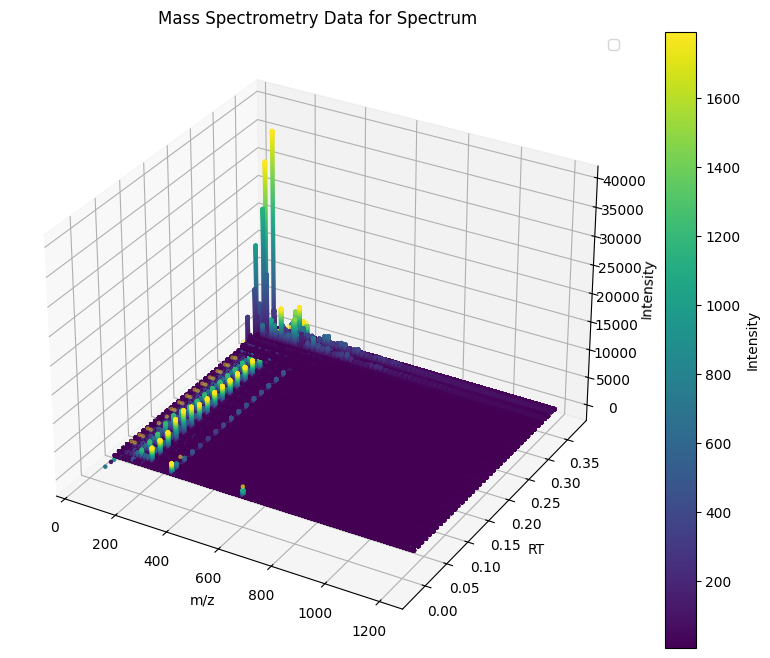

In [41]:
plot_spectrum_3d(spectrums)

## Normalization

We are considering cross samples.

**Intensity drift** -> Instrument response changes with time; *drift* can occur when samples are collected over multiple batches or over a long period of time, so it's important to normalize.

### Methods
- Sum (or median) metabolite signal intensity normalization (assumes all metabolites experience same pattern or drift, which may not always be true, and that sum/median is approx. same in all samples)
- Quality Control samples (included in each batch, can monitor and adjust for drift)
- Summarization of replicates if used (summarize **technical replicates** to result in one measure/subject/compound)
  - Coefficient of variation across replicates -> depending on low or high, we can use different summaries
  - On low we can use mean as a summary, the high ones we might want to exclude or use median
- Missing data
  - Compound of not present sample
  - Compound present, but below the detectable limit, noise level
  - Compound failed to be identified
  - Missing completely at Random (MCAR)
  - Missing not at Random (MNAR)
- Imputation
  - Downstream analysis need complete data
- Batch effects
  - Although quality control samples can adjust for drift, they may have additional variation due to measured and unmeasured factors
  - Utilize internal control to measure variation (Spiked or Biological controls)
  - Data driven strategies
  - Batch Effects (Empirical Bayes Method)


### Normalization strategies

- Quantile normalization
- Surrogate Variable Analysis
- Remove unwanted variation - metabolomics RUVm
- Cross Contribution Normalization 

#### Quantile normalization

Quantile normalization is an important normalization technique commonly used in high-dimensional data analysis. This is why I chose it.

A general strategy, common to many normalization techniques, is to re-distribute signal intensities across all samples such that they now all have the same distribution (e.g. same mean and/or standard deviation).

Common examples of normalization techniques include linear scaling (also known as min–max scaling), Z-normalization, and rank-scaling (also known as linear interpolation).

More information: https://www.nature.com/articles/s41598-020-72664-6

The specific strategy I am using is called **smooth quantile normalization** based on this article: https://academic.oup.com/biostatistics/article/19/2/185/3949169. It uses rank-scaling

<div>
<img src="./images/data-preprocessing/quantile_norm.png" width="500">
</div>

In [20]:
import numpy as np

In [21]:
def quantile_normalization(spectrums: pd.DataFrame, smooth_factor=1e-10):
    grouped = spectrums.groupby("id")

    normalized_data = pd.DataFrame()

    for _, group_spectrums in grouped:
        num_rows = group_spectrums.shape[0]
        ranked_data = group_spectrums["intensity"].rank()
        quantiles = (ranked_data - 0.5) / num_rows
        quantiles_smoothed = quantiles + smooth_factor

        normalization_factor = np.exp(-np.mean(np.log(quantiles_smoothed)))

        normalized_group = group_spectrums.copy()
        normalized_group["intensity"] = group_spectrums["intensity"] / normalization_factor

        normalized_data = pd.concat([normalized_data, normalized_group])

    return normalized_data

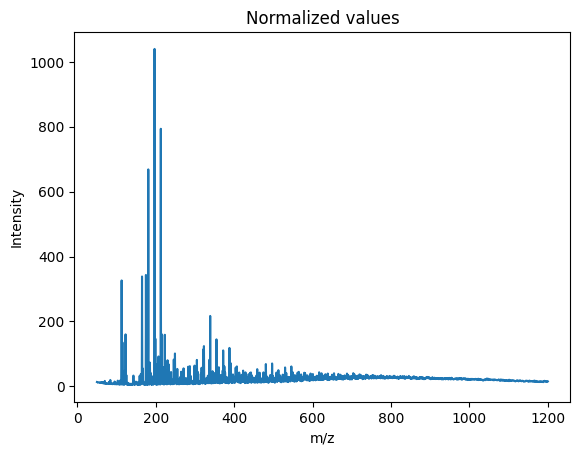

In [22]:
normalized_spectrum = quantile_normalization(organized_spectrum)
plt.plot(normalized_spectrum["m/z"], normalized_spectrum["intensity"])
plt.xlabel('m/z')
plt.ylabel('Intensity')
plt.title('Normalized values')

plt.show()

### Missing Data Methods
- Remove compound with too many missing values
  - Removed uncommon metabolites
  - Consider impact on downstream analysis
    - Too stringent reduces power and might miss importent compounds
    - Too lenient increases false positives and drug/food metabolites
    
### Imputation strategies
- With Zero -> Zero remain in database
  - Normalization and some statistical analysis are no longer valid
- Minimum value -> All missing values are replaced with the $1/2$ the minimum value observed for compound (could reduce standard deviation)
- Random Forests
- K-Nearest Neighbours
- Bayesian Principal Component Analysis

## PyOpenMS algorithm steps

**Mass Trace Detection** -> define treshold value (ex. $10^4$, anything below this is considered noise)

**Elution peak detection** -> convolution, detects local min and max and separates them in two different peaks

**Feature finder** -> assembles metabolite features to singleton mass traces

**Map alignment** -> performs a linear retention time alignment, to correct for linear shifts in retention time

**Feature linking** -> links features from different files together

**Feature table**

In [23]:
pip install pyopenms

Note: you may need to restart the kernel to use updated packages.


In [24]:
import pyopenms


mzml_file = "../../mzml_data/test.mzML"
exp = pyopenms.MSExperiment()
pyopenms.MzMLFile().load(mzml_file, exp)

mass_traces = []
mtd = pyopenms.MassTraceDetection()
mtd_par = mtd.getDefaults() # get the default parameters in order to edit them
mtd_par.setValue("mass_error_ppm", 10.0) # high-res instrument, orbitraps
mtd_par.setValue("noise_threshold_int", 1.0e04) # data-dependent (usually works for orbitraps)
mtd.setParameters(mtd_par) # set the new parameters
mtd.run(exp, mass_traces, 0) # run mass trace detection

Progress of 'mass trace detection':
-- done [took 0.04 s (CPU), 0.04 s (Wall)] -- 


In [25]:
plt.figure(figsize=(10, 6))
for idx, trace in enumerate(mass_traces):
    centroid_mz = trace.getCentroidMZ()
    centroid_rt = trace.getCentroidRT()
    smoothed_intensities = trace.getCentroidSD()

    # Plotting the mass trace
    # plt.plot(centroid_rt, smoothed_intensities, label=f"Trace {idx + 1}, Centroid m/z: {centroid_mz}")


<Figure size 1000x600 with 0 Axes>

In [26]:
print("Elution Peak Detection: ", mzml_file)
mass_traces_deconvol = []
epd = pyopenms.ElutionPeakDetection()
epd_par = epd.getDefaults()
epd_par.setValue("width_filtering", "fixed") # The fixed setting filters out mass traces outside the [min_fwhm: 1.0, max_fwhm: 60.0] interval
epd.setParameters(epd_par)
epd.detectPeaks(mass_traces, mass_traces_deconvol)

Elution Peak Detection:  ../../mzml_data/test.mzML
Progress of 'elution peak detection':
-- done [took 0.45 s (CPU), 0.04 s (Wall)] -- 
